<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candida

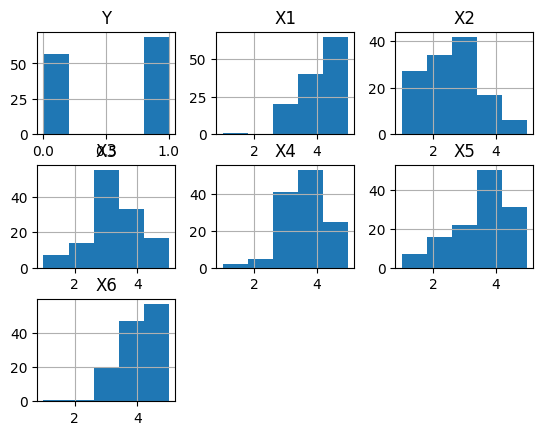

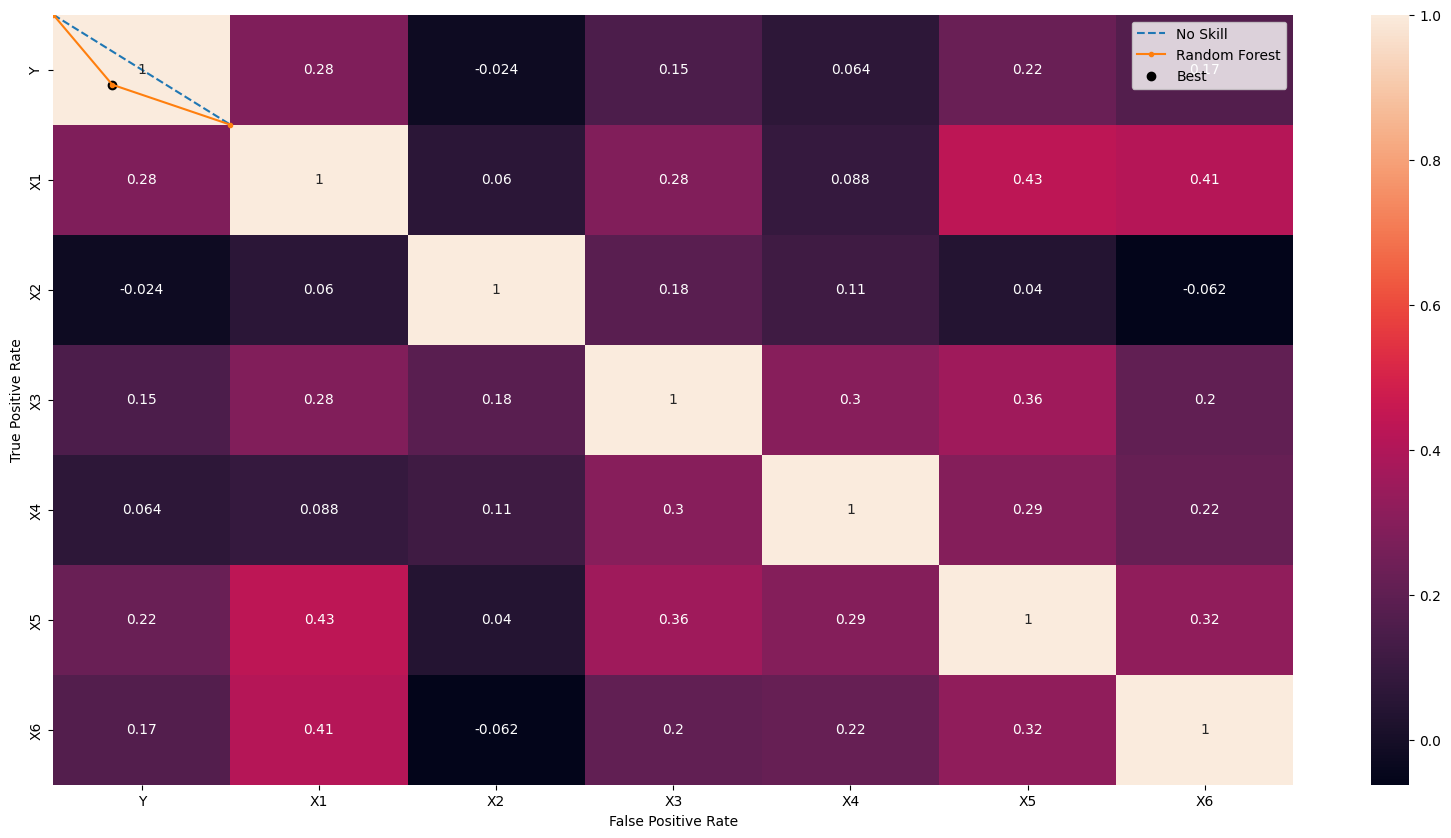

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Nested CV Average Score for SVC: 0.5300
Best Parameters for SVC: {'kernel': 'poly', 'gamma': 0.1, 'C': 10}
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each 

In [16]:
#Import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import sqrt
from numpy import argmax

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#loading the data
happy=pd.read_csv('ACME-HappinessSurvey2020.csv')
happy.head()

happy.shape

happy.info()

#See columns in data
happy.columns

happy.describe()

happy.isnull().sum() #There are no null variables, all numerical data

#Data Exploration

happy.hist(bins=5)

#Visualisation of target column relative frequency
happy['Y'].value_counts().plot(kind='pie',autopct='%1.2f%%',title='Proportion of Happy Customers')
#Data is not completely unbalanced

#Correlation between variables
plt.figure(figsize=(20,10))
sns.heatmap(happy.corr(),annot=True)
happy.corr() #No multicollinearity

#Data Modeling

#Importing "train_test-split" function to test the model
from sklearn.model_selection import train_test_split

#Splitting the data
X=happy.drop(['Y'],axis=1)
y=happy['Y']

#Model Comparison using automatic nested cross-validation
# Compare classification algorithms
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#One Hot Encoding train and test set separately
ohe=OneHotEncoder(sparse=False,handle_unknown="ignore")
X_train=ohe.fit_transform(X_train)
X_test=ohe.transform(X_test)

# Set up the inner cross-validation
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Set up the outer cross-validation
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

#Randomized Search with Random Forest Classifier
np.random.seed(0)
rf = RandomForestClassifier(random_state=0)
#Define the hyperparameter grid
rf_param_grid = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'min_samples_leaf': [1, 2, 4, 25],
              'min_samples_split': [2, 5, 10, 25],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]}
grid_search_rf = RandomizedSearchCV(rf, rf_param_grid, cv=inner_cv, n_iter=100, n_jobs=-1, scoring='accuracy', verbose=1, refit=True)
nested_scores_rf = cross_val_score(grid_search_rf, X_train, y_train, cv=outer_cv, scoring = 'accuracy')

rf_search=grid_search_rf.fit(X_train, y_train)
grid_search_rf.best_estimator_.score(X_test, y_test)

print(f"Nested CV Average Score for RandomForest: {nested_scores_rf.mean():.4f}")
print(f"Best Parameters for RandomForest: {rf_search.best_params_}")

# predict probabilities
# keep probabilities for the positive outcome only
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, rf_search.predict_proba(X_test)[:,1])
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

        
#Randomized Search with SVC
np.random.seed(1)
svc_inner_cv = KFold(n_splits=5, shuffle=True, random_state=23)
svc_outer_cv = KFold(n_splits=10, shuffle=True, random_state=23)
svc = SVC()
#Define the hyperparameter grid
param_gridsvc = {'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf','linear', 'poly', 'sigmoid']}
grid_search_svc = RandomizedSearchCV(svc, param_gridsvc, cv=svc_inner_cv, n_iter=100, n_jobs=-1, scoring='accuracy', verbose=1, refit=True)
nested_scores_svc = cross_val_score(grid_search_svc, X_train, y_train, cv=svc_outer_cv, scoring = 'accuracy')

svc_search=grid_search_svc.fit(X_train, y_train)
grid_search_svc.best_estimator_.score(X_test, y_test)

print(f"Nested CV Average Score for SVC: {nested_scores_svc.mean():.4f}")
print(f"Best Parameters for SVC: {svc_search.best_params_}")

#Randomized Search with Decision Tree Classifier
np.random.seed(2)
dt_inner_cv = KFold(n_splits=5, shuffle=True, random_state=15)
dt_outer_cv = KFold(n_splits=10, shuffle=True, random_state=15)
dt = DecisionTreeClassifier()
#Define the hyperparameter grid
dt_param_grid = {'max_depth': [1, 10, 20, 30, 50],
              'max_features': [1, 2, 3, 4, 5]}
grid_search_dt = RandomizedSearchCV(dt, dt_param_grid, cv=dt_inner_cv, n_iter=100, n_jobs=-1, scoring='accuracy', verbose=1, refit=True)
nested_scores_dt = cross_val_score(grid_search_dt, X_train, y_train, cv=dt_outer_cv, scoring = 'accuracy')

dt_search=grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_estimator_.score(X_test, y_test)

print(f"Nested CV Average Score for Decision Tree: {nested_scores_dt.mean():.4f}")
print(f"Best Parameters for Decision Tree: {dt_search.best_params_}")

#Randomized Search with Logistic Regression
np.random.seed(3)
lg_inner_cv = KFold(n_splits=5, shuffle=True, random_state=15)
lg_outer_cv = KFold(n_splits=10, shuffle=True, random_state=15)
lg = LogisticRegression()
#Define the hyperparameter grid
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
lg_search=grid_search_lg = RandomizedSearchCV(lg, space, cv=lg_inner_cv, n_iter=100, n_jobs=-1, scoring='accuracy', verbose=1, refit=True)
nested_scores_lg = cross_val_score(grid_search_lg, X_train, y_train, cv=lg_outer_cv, scoring = 'accuracy')

grid_search_lg.fit(X_train, y_train)
grid_search_lg.best_estimator_.score(X_test, y_test)

print(f"Nested CV Average Score for Logistic Regression: {nested_scores_lg.mean():.4f}")
print(f"Best Parameters for Logistic Regression: {lg_search.best_params_}")

#FEATURE SELECTION

#Selecting best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

for n_features in range(1,7):
    for i in range(0,50): 
        X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=i)
        rf_best=RandomForestClassifier(n_estimators= 4, min_samples_split=25, min_samples_leaf= 25, max_features= None,max_depth= 60, criterion= 'gini', bootstrap= False)
        chi2_features = SelectKBest(chi2, k=n_features)
        X_kbest = chi2_features.fit_transform(X_train2,y_train2)
        chi2_features.get_support() 
        selected_feat=X_train2.columns[(chi2_features.get_support())] 
        X_train_sub = X_train2[selected_feat]
        X_test_sub = X_test2[selected_feat]
        #Two models
        rf_full = rf_best.fit(X_train2, y_train2)
        rf_sub = rf_best.fit(X_train_sub, y_train2)
        # Unbiased estimate of OOF performance
        
        print(accuracy_score(y_test2, rf_sub.predict(X_test_sub)))